In [8]:
from commonfunctions import *
import numpy as np
import skimage
import skimage.io as io
import matplotlib.pyplot as plt
from skimage import filters, feature
from skimage.color import rgb2gray
from skimage.morphology import binary_erosion, binary_dilation, binary_closing,skeletonize, thin
from skimage.measure import find_contours
from skimage.draw import rectangle
import cv2 as cv

# Convolution:
from scipy.signal import convolve2d
from scipy import fftpack
import math

# Show the figures / plots inside the notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
from skimage import io, color, filters, restoration, exposure, transform, morphology, measure
import numpy as np
from scipy.ndimage import median_filter

def detect_issues(image):
    issues = {}
    # Convert to grayscale
    gray = color.rgb2gray(image)

    # Noise detection: Use Laplacian variance
    laplacian_var = filters.laplace(gray).var()
    issues['noise'] = laplacian_var < 0.01  # Threshold for noise detection

    # Detect low contrast
    contrast_ratio = exposure.is_low_contrast(gray, fraction_threshold=0.35)
    issues['low_contrast'] = contrast_ratio

    # Detect blur using edge sharpness (Sobel filter)
    edge_sharpness = filters.sobel(gray).var()
    issues['blur'] = edge_sharpness < 0.005  # Adjust threshold for blur detection

    return issues

def preprocess_image(image):
    issues = detect_issues(image)

    # 1. Solve salt-and-pepper noise using median filtering
    if issues.get('noise'):
        image = median_filter(image, size=3)

    # 2. Solve additive noise using bilateral filtering
    if issues.get('noise'):
        image = restoration.denoise_bilateral(image, sigma_color=0.05, sigma_spatial=15, multichannel=True)

    # 3. Solve low contrast or lighting problems
    if issues.get('low_contrast'):
        image = exposure.equalize_adapthist(image, clip_limit=0.03)

    # 4. Solve blur using Wiener deconvolution
    if issues.get('blur'):
        psf = np.ones((5, 5)) / 25
        gray = color.rgb2gray(image)
        deblurred, _ = restoration.unsupervised_wiener(gray, psf)
        image = color.gray2rgb(deblurred)

    # 5. Correct perspective (angle distortion)
    edges = filters.sobel(color.rgb2gray(image))
    contours = measure.find_contours(edges, 0.5)
    largest_contour = max(contours, key=len)

    # Create binary mask and convex hull
    binary_mask = np.zeros_like(edges, dtype=bool)
    for coord in largest_contour.astype(int):
        binary_mask[coord[0], coord[1]] = True
    convex_hull = morphology.convex_hull_image(binary_mask)
    labeled_hull = measure.label(convex_hull)

    # Extract bounding box and crop
    props = measure.regionprops_table(labeled_hull, properties=['bbox'])
    minr, minc, maxr, maxc = props['bbox-0'][0], props['bbox-1'][0], props['bbox-2'][0], props['bbox-3'][0]
    cropped = image[minr:maxr, minc:maxc]
    image = transform.resize(cropped, (300, 600))

    # 6. Remove fog or haze using histogram stretching
    image = exposure.rescale_intensity(image, in_range='image', out_range=(0, 1))

    return image


In [10]:
import numpy as np
import cv2
from skimage import io, color, filters, restoration, exposure
from scipy.ndimage import median_filter
import os

# Function to preprocess images (enhance image quality)
def preprocess_image(image):
    try:
        # Convert to grayscale
        gray = color.rgb2gray(image)

        # Noise detection: Use Laplacian variance
        laplacian_var = filters.laplace(gray).var()
        noise = laplacian_var < 0.02  # Adjusted threshold for noise detection

        # Solve salt-and-pepper noise using median filtering
        if noise:
            gray = median_filter(gray, size=3)  # Adjust filter size if needed

        # Solve low contrast or lighting problems
        if exposure.is_low_contrast(gray, fraction_threshold=0.35):
            gray = exposure.equalize_adapthist(gray, clip_limit=0.03)  # CLAHE

        # Solve blur using Wiener deconvolution
        edge_sharpness = filters.sobel(gray).var()
        if edge_sharpness < 0.005:  # Adjusted threshold for blur detection
            psf = np.ones((5, 5)) / 25  # Point Spread Function for motion blur
            deblurred, _ = restoration.unsupervised_wiener(gray, psf)
            gray = deblurred

        return (gray * 255).astype(np.uint8)  # Return preprocessed grayscale image
    except Exception as e:
        print(f"Error in preprocessing image: {e}")
        return None

# Function to create SIFT templates from collected images
def create_sift_templates(image_paths):
    templates = []
    template_keypoints = []
    template_images = []
    sift = cv2.SIFT_create()  # Using OpenCV's SIFT implementation

    for image_path in image_paths:
        try:
            # Read and preprocess the image
            image = io.imread(image_path)
            preprocessed_image = preprocess_image(image)
            if preprocessed_image is None:
                continue

            # Detect keypoints and descriptors
            keypoints, descriptors = sift.detectAndCompute(preprocessed_image, None)

            if descriptors is not None:
                templates.append(descriptors)
                template_keypoints.append(keypoints)
                template_images.append(image)
        except FileNotFoundError:
            print(f"Error: File {image_path} not found.")
        except Exception as e:
            print(f"Error processing file {image_path}: {e}")

    return templates, template_keypoints, template_images

# Function to test and extract features
def test_and_extract_features(template_descriptors, template_keypoints, template_images, test_image_paths, output_dir="output"):
    sift = cv2.SIFT_create()
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

    for image_path in test_image_paths:
        try:
            # Read test image
            test_image = io.imread(image_path)
            preprocessed_test_image = preprocess_image(test_image)
            if preprocessed_test_image is None:
                continue

            # Detect keypoints and descriptors in test image
            keypoints_test, descriptors_test = sift.detectAndCompute(preprocessed_test_image, None)
            if descriptors_test is None:
                print(f"No descriptors found in test image: {image_path}")
                continue

            # Loop through template descriptors and match features
            for template, keypoints_template, template_image in zip(template_descriptors, template_keypoints, template_images):
                bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
                knn_matches = bf.knnMatch(template, descriptors_test, k=2)

                # Apply Lowe's ratio test
                good_matches = [m for m, n in knn_matches if m.distance < 0.75 * n.distance]
                if len(good_matches) == 0:
                    continue

                # Draw matches for visualization
                matched_image = cv2.drawMatches(
                    cv2.cvtColor(template_image, cv2.COLOR_RGB2BGR), keypoints_template,
                    cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR), keypoints_test,
                    good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                )

                # Save the matched visualization
                match_output_path = os.path.join(output_dir, f"matched_{os.path.basename(image_path)}")
                cv2.imwrite(match_output_path, matched_image)
                print(f"Feature match visualization saved to: {match_output_path}")

                # Extract and save matched regions
                matched_points = [keypoints_test[m.trainIdx].pt for m in good_matches]
                x_coords, y_coords = zip(*matched_points)
                x_min, x_max = int(min(x_coords)), int(max(x_coords))
                y_min, y_max = int(min(y_coords)), int(max(y_coords))

                # Extract region of interest (ROI)
                roi = test_image[y_min:y_max, x_min:x_max]
                roi_output_path = os.path.join(output_dir, f"roi_{os.path.basename(image_path)}")
                io.imsave(roi_output_path, roi)
                print(f"Extracted region saved to: {roi_output_path}")

        except FileNotFoundError:
            print(f"Error: File {image_path} not found.")
        except Exception as e:
            print(f"Error processing test file {image_path}: {e}")

# Example usage
if __name__ == "__main__":
    # Collect images of license plates from different countries
    image_paths = [
        'template/7345147d48f03.png'
    ]  # Replace with your image paths
    template_descriptors, template_keypoints, template_images = create_sift_templates(image_paths)

    # Test images for validation
    test_image_paths = [
          'de47991.jpg', 'de11904.jpg'
    ]  # Replace with your test image paths
    test_and_extract_features(template_descriptors, template_keypoints, template_images, test_image_paths, output_dir="output_features")


Error: File template/7345147d48f03.png not found.
Error: File de47991.jpg not found.
Error: File de11904.jpg not found.


In [11]:
import cv2
import numpy as np
from skimage import color, filters, exposure
from scipy.ndimage import median_filter
from skimage import restoration

# Function to preprocess images (enhance image quality)
def preprocess_image(image):
    try:
        # Convert to grayscale if image has 3 channels (RGB)
        if len(image.shape) == 3 and image.shape[2] == 3:
            gray = color.rgb2gray(image)
        else:
            gray = image  # If already grayscale, skip conversion

        # Noise detection: Use Laplacian variance
        laplacian_var = filters.laplace(gray).var()
        noise = laplacian_var < 0.02  # Adjusted threshold for noise detection

        # Solve salt-and-pepper noise using median filtering
        if noise:
            gray = median_filter(gray, size=3)  # Adjust filter size if needed

        # Solve low contrast or lighting problems
        if exposure.is_low_contrast(gray, fraction_threshold=0.35):
            gray = exposure.equalize_adapthist(gray, clip_limit=0.03)  # CLAHE

        # Solve blur using Wiener deconvolution
        edge_sharpness = filters.sobel(gray).var()
        if edge_sharpness < 0.005:  # Adjusted threshold for blur detection
            psf = np.ones((5, 5)) / 25  # Point Spread Function for motion blur
            deblurred, _ = restoration.unsupervised_wiener(gray, psf)
            gray = deblurred

        return (gray * 255).astype(np.uint8)  # Return preprocessed grayscale image
    except Exception as e:
        print(f"Error in preprocessing image: {e}")
        return None



# Main function for license plate recognition
def recognize_license_plate(image_path):
    # Read and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (800, 600))  # Resize for standardization
    preprocessed_image = preprocess_image(image)

    if preprocessed_image is None:
        print("Error preprocessing image.")
        return

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Perform edge detection
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edged = cv2.Canny(blur, 200, 255)

    # Find contours
    contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    n_plate_cnt = None
    for c in contours:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        if len(approx) == 4:
            n_plate_cnt = approx
            (x, y, w, h) = cv2.boundingRect(n_plate_cnt)
            license_plate = gray[y:y + h, x:x + w]
            break

    if n_plate_cnt is not None:
        # Draw contours and license plate region
        cv2.drawContours(image, [n_plate_cnt], -1, (0, 255, 0), 3)
        show_images([image, blur, edged])
        print("License plate detected and processed.")
    else:
        print("No license plate found.")

# Run license plate recognition on a sample image
recognize_license_plate('16.jpg')


No license plate found.


In [12]:
#Number Plate Recognition with OpenCV and EasyOCR
import cv2

    
image = cv2.imread('11.jpg')
image = cv2.resize(image, (800, 600))

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)




blur = cv2.GaussianBlur(gray, (5,5), 0)
edged = cv2.Canny(blur, 190, 255)
contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:5]

for c in contours:
    peri = cv2.arcLength(c, True)
    
    approx = cv2.approxPolyDP(c,0.02*peri, True)
    if len(approx) == 4:
        n_plate_cnt = approx
        (x, y, w, h) = cv2.boundingRect(n_plate_cnt)
        license_plate = gray[y:y + h, x:x + w]
        break


cv2.drawContours(image, [n_plate_cnt], -1, (0, 255, 0), 3)
show_images( [image,blur,edged ])

NameError: name 'n_plate_cnt' is not defined

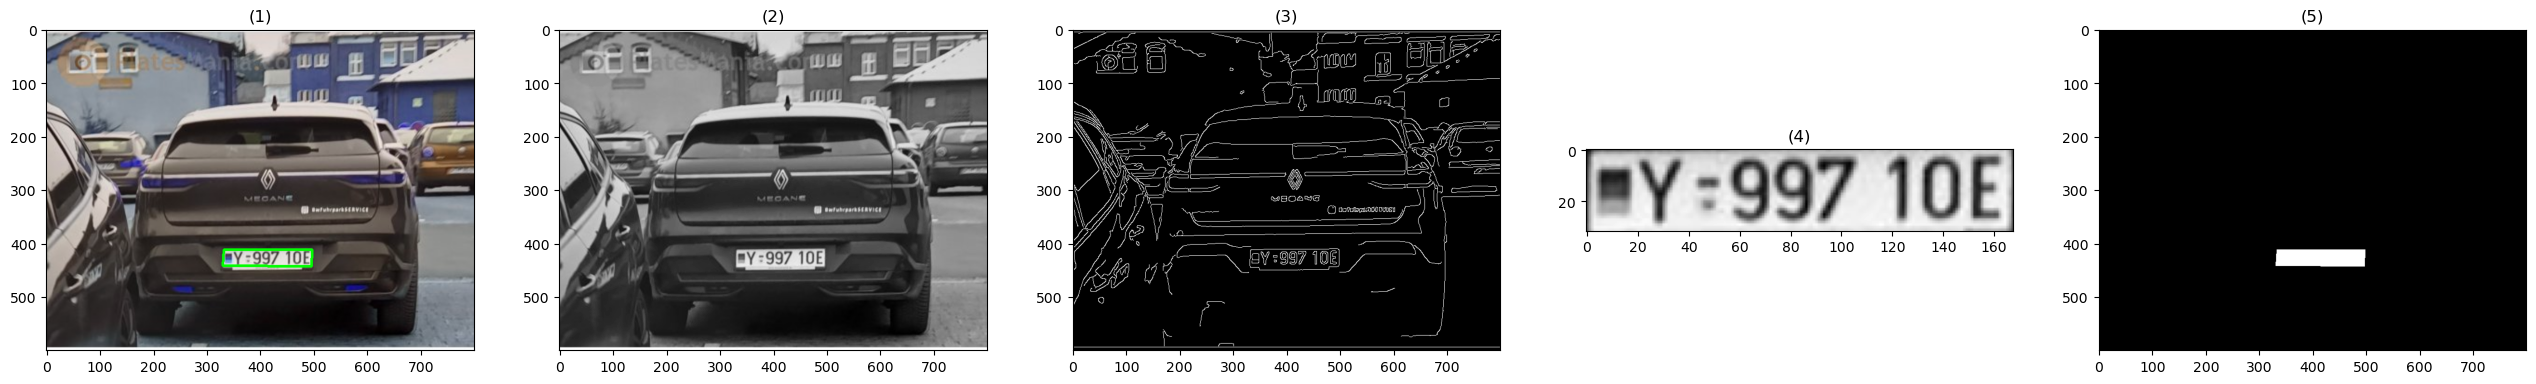

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils

img = cv2.imread('16.jpg')
if img.shape[0] < 800 and img.shape[1] < 600:
    img = cv2.resize(img, (800, 600))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 200) #Edge detection

keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]


location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour,10, True)
    if len(approx) == 4:
        location = approx
        break

mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)



(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]
cv2.drawContours(img, [location], -1, (0, 255, 0), 3)
show_images([img,gray,edged ,cropped_image,mask])



In [ ]:
import numpy as np
import cv2
from skimage import io, color, filters, restoration, exposure
from scipy.ndimage import median_filter
import os

# Function to preprocess images (enhance image quality)
def preprocess_image(image):
    try:
        # Convert to grayscale
        gray = color.rgb2gray(image)

        # Noise detection: Use Laplacian variance
        laplacian_var = filters.laplace(gray).var()
        noise = laplacian_var < 0.02  # Adjusted threshold for noise detection

        # Solve salt-and-pepper noise using median filtering
        if noise:
            gray = median_filter(gray, size=3)  # Adjust filter size if needed

        # Solve low contrast or lighting problems
        if exposure.is_low_contrast(gray, fraction_threshold=0.35):
            gray = exposure.equalize_adapthist(gray, clip_limit=0.03)  # CLAHE

        # Solve blur using Wiener deconvolution
        edge_sharpness = filters.sobel(gray).var()
        if edge_sharpness < 0.005:  # Adjusted threshold for blur detection
            psf = np.ones((5, 5)) / 25  # Point Spread Function for motion blur
            deblurred, _ = restoration.unsupervised_wiener(gray, psf)
            gray = deblurred

        return (gray * 255).astype(np.uint8)  # Return preprocessed grayscale image
    except Exception as e:
        print(f"Error in preprocessing image: {e}")
        return None

# Function to create SIFT templates from collected images
def create_sift_templates(image_paths):
    templates = []
    template_keypoints = []
    template_images = []
    sift = cv2.SIFT_create()  # Using OpenCV's SIFT implementation

    for image_path in image_paths:
        try:
            # Read and preprocess the image
            image = io.imread(image_path)
            preprocessed_image = preprocess_image(image)
            if preprocessed_image is None:
                continue

            # Detect keypoints and descriptors
            keypoints, descriptors = sift.detectAndCompute(preprocessed_image, None)

            if descriptors is not None:
                templates.append(descriptors)
                template_keypoints.append(keypoints)
                template_images.append(image)
        except FileNotFoundError:
            print(f"Error: File {image_path} not found.")
        except Exception as e:
            print(f"Error processing file {image_path}: {e}")

    return templates, template_keypoints, template_images

# Function to test and extract features from the best matching template
def test_and_extract_features(template_descriptors, template_keypoints, template_images, test_image_paths, output_dir="output"):
    sift = cv2.SIFT_create()
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

    for image_path in test_image_paths:
        try:
            # Read test image
            test_image = io.imread(image_path)
            preprocessed_test_image = preprocess_image(test_image)
            if preprocessed_test_image is None:
                continue

            # Detect keypoints and descriptors in test image
            keypoints_test, descriptors_test = sift.detectAndCompute(preprocessed_test_image, None)
            if descriptors_test is None:
                print(f"No descriptors found in test image: {image_path}")
                continue

            best_match_score = 0
            best_matched_template = None
            best_matched_image = None
            best_good_matches = []
            best_keypoints_test = []

            # Loop through template descriptors and match features
            for template, keypoints_template, template_image in zip(template_descriptors, template_keypoints, template_images):
                bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
                knn_matches = bf.knnMatch(template, descriptors_test, k=2)

                # Apply Lowe's ratio test
                good_matches = [m for m, n in knn_matches if m.distance < 0.75 * n.distance]
                if len(good_matches) == 0:
                    continue

                # Check if this template has the best match score
                if len(good_matches) > best_match_score:
                    best_match_score = len(good_matches)
                    best_matched_template = template_image
                    best_matched_image = test_image
                    best_good_matches = good_matches
                    best_keypoints_test = keypoints_test

            if best_matched_template is not None:
                # Draw matches for visualization
                matched_image = cv2.drawMatches(
                    cv2.cvtColor(best_matched_template, cv2.COLOR_RGB2BGR), keypoints_template,
                    cv2.cvtColor(best_matched_image, cv2.COLOR_RGB2BGR), best_keypoints_test,
                    best_good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                )

                # Save the matched visualization
                match_output_path = os.path.join(output_dir, f"matched_{os.path.basename(image_path)}")
                cv2.imwrite(match_output_path, matched_image)
                print(f"Feature match visualization saved to: {match_output_path}")

                # Extract and save matched regions (ROI) from the best-matched template
                matched_points = [best_keypoints_test[m.trainIdx].pt for m in best_good_matches]
                x_coords, y_coords = zip(*matched_points)
                x_min, x_max = int(min(x_coords)), int(max(x_coords))
                y_min, y_max = int(min(y_coords)), int(max(y_coords))

                # Extract region of interest (ROI) from the best-matched region
                roi = best_matched_image[y_min:y_max, x_min:x_max]
                roi_output_path = os.path.join(output_dir, f"roi_best_match_{os.path.basename(image_path)}")
                io.imsave(roi_output_path, roi)
                print(f"Extracted region saved to: {roi_output_path}")

        except FileNotFoundError:
            print(f"Error: File {image_path} not found.")
        except Exception as e:
            print(f"Error processing test file {image_path}: {e}")

# Example usage
if __name__ == "__main__":
    # Collect images of license plates from different countries (multiple templates)
    image_paths = [
        'template/1.png',
         'template/2.png',
         'template/3.png' ,
         'template/4.png',
         'template/5.png',
         'template/6.png',
         'template/7.png',
         'template/8.png',
         'template/9.png'
                 
    ]  # Replace with your image paths
    template_descriptors, template_keypoints, template_images = create_sift_templates(image_paths)

    # Test images for validation
    test_image_paths = [
        '3.jpg',
        '4.jpg' , 
        '5.jpg'  # Add more test image paths here
    ]  # Replace with your test image paths
    test_and_extract_features(template_descriptors, template_keypoints, template_images, test_image_paths, output_dir="output_featuress")


Error in preprocessing image: the input array must have size 3 along `channel_axis`, got (50, 235, 4)
Feature match visualization saved to: output_featuress\matched_5.jpg
Extracted region saved to: output_featuress\roi_best_match_5.jpg


In [ ]:
import numpy as np
import cv2
from skimage import io, color, filters, restoration, exposure
from scipy.ndimage import median_filter
import os

# Function to preprocess images (enhance image quality)
def preprocess_image(image):
    try:
        # Check if the image has 4 channels (RGBA), and if so, remove the alpha channel
        if image.shape[-1] == 4:
            image = image[..., :3]  # Remove alpha channel, leaving only RGB

        # Convert to grayscale
        gray = color.rgb2gray(image)

        # Noise detection: Use Laplacian variance
        laplacian_var = filters.laplace(gray).var()
        noise = laplacian_var < 0.02  # Adjusted threshold for noise detection

        # Solve salt-and-pepper noise using median filtering
        if noise:
            gray = median_filter(gray, size=3)  # Adjust filter size if needed

        # Solve low contrast or lighting problems
        if exposure.is_low_contrast(gray, fraction_threshold=0.35):
            gray = exposure.equalize_adapthist(gray, clip_limit=0.03)  # CLAHE

        # Solve blur using Wiener deconvolution
        edge_sharpness = filters.sobel(gray).var()
        if edge_sharpness < 0.005:  # Adjusted threshold for blur detection
            psf = np.ones((5, 5)) / 25  # Point Spread Function for motion blur
            deblurred, _ = restoration.unsupervised_wiener(gray, psf)
            gray = deblurred

        return (gray * 255).astype(np.uint8)  # Return preprocessed grayscale image
    except Exception as e:
        print(f"Error in preprocessing image: {e}")
        return None

# Function to create SIFT templates from collected images
def create_sift_templates(image_paths):
    templates = []
    template_keypoints = []
    template_images = []
    sift = cv2.SIFT_create()  # Using OpenCV's SIFT implementation

    for image_path in image_paths:
        try:
            # Read and preprocess the image
            image = io.imread(image_path)
            preprocessed_image = preprocess_image(image)
            if preprocessed_image is None:
                continue

            # Detect keypoints and descriptors
            keypoints, descriptors = sift.detectAndCompute(preprocessed_image, None)

            if descriptors is not None:
                templates.append(descriptors)
                template_keypoints.append(keypoints)
                template_images.append(image)
        except FileNotFoundError:
            print(f"Error: File {image_path} not found.")
        except Exception as e:
            print(f"Error processing file {image_path}: {e}")

    return templates, template_keypoints, template_images

# Function to test and extract features from the best matching template
def test_and_extract_features(template_descriptors, template_keypoints, template_images, test_image_paths, output_dir="output"):
    sift = cv2.SIFT_create()
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

    for image_path in test_image_paths:
        try:
            # Read test image
            test_image = io.imread(image_path)
            preprocessed_test_image = preprocess_image(test_image)
            if preprocessed_test_image is None:
                continue

            # Detect keypoints and descriptors in test image
            keypoints_test, descriptors_test = sift.detectAndCompute(preprocessed_test_image, None)
            if descriptors_test is None:
                print(f"No descriptors found in test image: {image_path}")
                continue

            best_match_score = 0
            best_matched_template = None
            best_matched_image = None
            best_good_matches = []
            best_keypoints_test = []

            # Loop through template descriptors and match features
            for template, keypoints_template, template_image in zip(template_descriptors, template_keypoints, template_images):
                bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
                knn_matches = bf.knnMatch(template, descriptors_test, k=2)

                # Apply Lowe's ratio test
                good_matches = [m for m, n in knn_matches if m.distance < 0.75 * n.distance]
                if len(good_matches) == 0:
                    continue

                # Check if this template has the best match score
                if len(good_matches) > best_match_score:
                    best_match_score = len(good_matches)
                    best_matched_template = template_image
                    best_matched_image = test_image
                    best_good_matches = good_matches
                    best_keypoints_test = keypoints_test

            if best_matched_template is not None:
                # Draw matches for visualization
                matched_image = cv2.drawMatches(
                    cv2.cvtColor(best_matched_template, cv2.COLOR_RGB2BGR), keypoints_template,
                    cv2.cvtColor(best_matched_image, cv2.COLOR_RGB2BGR), best_keypoints_test,
                    best_good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                )

                # Save the matched visualization
                match_output_path = os.path.join(output_dir, f"matched_{os.path.basename(image_path)}")
                cv2.imwrite(match_output_path, matched_image)
                print(f"Feature match visualization saved to: {match_output_path}")

                # Extract and save matched regions (ROI) from the best-matched template
                if len(best_good_matches) > 0:
                    matched_points = [best_keypoints_test[m.trainIdx].pt for m in best_good_matches]
                    x_coords, y_coords = zip(*matched_points)
                    x_min, x_max = int(min(x_coords)), int(max(x_coords))
                    y_min, y_max = int(min(y_coords)), int(max(y_coords))

                    # Extract region of interest (ROI) from the best-matched region
                    roi = best_matched_image[y_min:y_max, x_min:x_max]
                    roi_output_path = os.path.join(output_dir, f"roi_best_match_{os.path.basename(image_path)}")
                    io.imsave(roi_output_path, roi)
                    print(f"Extracted region saved to: {roi_output_path}")

        except FileNotFoundError:
            print(f"Error: File {image_path} not found.")
        except Exception as e:
            print(f"Error processing test file {image_path}: {e}")

# Example usage
if __name__ == "__main__":
    # Collect images of license plates from different countries (multiple templates)
    image_paths = [
        'template/1.png',
         'template/2.png',
         'template/3.png' ,
         'template/4.png',
         'template/5.png',
         'template/6.png',
         'template/7.png',
         'template/8.png',
         'template/9.png'
                  ]  # Replace with your image paths
    template_descriptors, template_keypoints, template_images = create_sift_templates(image_paths)

    # Test images for validation
    test_image_paths = [
        '3.jpg',
        '4.jpg' , 
        '5.jpg' ,
        '6.jpg',
        '7.jpg',
        '8.jpg' 
    ]  # Replace with your test image paths
    test_and_extract_features(template_descriptors, template_keypoints, template_images, test_image_paths, output_dir="output_featuress")


Feature match visualization saved to: output_featuress\matched_3.jpg
Extracted region saved to: output_featuress\roi_best_match_3.jpg
Feature match visualization saved to: output_featuress\matched_5.jpg
Extracted region saved to: output_featuress\roi_best_match_5.jpg
Feature match visualization saved to: output_featuress\matched_6.jpg
Extracted region saved to: output_featuress\roi_best_match_6.jpg
Feature match visualization saved to: output_featuress\matched_7.jpg
Extracted region saved to: output_featuress\roi_best_match_7.jpg
Feature match visualization saved to: output_featuress\matched_8.jpg
Error processing test file 8.jpg: index -1 is out of bounds for axis 0 with size 0


In [ ]:
import numpy as np
import cv2
from skimage import io, color, filters, restoration, exposure
from scipy.ndimage import median_filter
import os

# Function to preprocess images (enhance image quality)
def preprocess_image(image):
    try:
        # Convert to grayscale
        gray = color.rgb2gray(image)

        # Noise detection: Use Laplacian variance
        laplacian_var = filters.laplace(gray).var()
        noise = laplacian_var < 0.02  # Adjusted threshold for noise detection

        # Solve salt-and-pepper noise using median filtering
        if noise:
            gray = median_filter(gray, size=3)  # Adjust filter size if needed

        # Solve low contrast or lighting problems
        if exposure.is_low_contrast(gray, fraction_threshold=0.35):
            gray = exposure.equalize_adapthist(gray, clip_limit=0.03)  # CLAHE

        # Solve blur using Wiener deconvolution
        edge_sharpness = filters.sobel(gray).var()
        if edge_sharpness < 0.005:  # Adjusted threshold for blur detection
            psf = np.ones((5, 5)) / 25  # Point Spread Function for motion blur
            deblurred, _ = restoration.unsupervised_wiener(gray, psf)
            gray = deblurred

        return (gray * 255).astype(np.uint8)  # Return preprocessed grayscale image
    except Exception as e:
        print(f"Error in preprocessing image: {e}")
        return None

# Function to create SIFT templates from collected images
def create_sift_templates(image_paths):
    templates = []
    sift = cv2.SIFT_create()  # Using OpenCV's SIFT implementation

    for image_path in image_paths:
        try:
            # Read and preprocess the image
            image = io.imread(image_path)
            preprocessed_image = preprocess_image(image)
            if preprocessed_image is None:
                continue

            # Detect keypoints and descriptors
            keypoints, descriptors = sift.detectAndCompute(preprocessed_image, None)

            if descriptors is not None:
                templates.append(descriptors)
        except FileNotFoundError:
            print(f"Error: File {image_path} not found.")
        except Exception as e:
            print(f"Error processing file {image_path}: {e}")

    return templates

# Function to test SIFT templates against test images
def test_license_plate_detection(template_descriptors, test_image_paths):
    sift = cv2.SIFT_create()  # Using OpenCV's SIFT implementation
    results = []

    for image_path in test_image_paths:
        try:
            # Read test image
            test_image = io.imread(image_path)
            preprocessed_test_image = preprocess_image(test_image)
            if preprocessed_test_image is None:
                continue

            # Detect keypoints and descriptors
            keypoints, descriptors = sift.detectAndCompute(preprocessed_test_image, None)

            if descriptors is None:
                results.append(0)  # No matches if no descriptors found
                continue

            # Match descriptors to templates using Lowe's ratio test
            matches = []
            for template in template_descriptors:
                bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
                knn_matches = bf.knnMatch(template, descriptors, k=2)
                good_matches = [m for m, n in knn_matches if m.distance < 0.75 * n.distance]
                matches.append(len(good_matches))

            # Append the best match count for this image
            results.append(max(matches))
        except FileNotFoundError:
            print(f"Error: File {image_path} not found.")
        except Exception as e:
            print(f"Error processing test file {image_path}: {e}")

    return results

# Example usage
if __name__ == "__main__":
    # Collect images of license plates from different countries
    image_paths = [
        'template/7345147d48f03.png', 
        'template/73346038a254d.png', 
        'template/73853859dbf49.png', 
        'template/111852278b44a3.png'
    ]  # Replace with your image paths
    template_descriptors = create_sift_templates(image_paths)

    # Test images for validation
    test_image_paths = [
        '396.jpg', '11185227.jpg', 'de47991.jpg', 'de11904.jpg'
    ]  # Replace with your test image paths
    results = test_license_plate_detection(template_descriptors, test_image_paths)

    print(f'Test Results: {results}')


Test Results: [2, 13, 5, 27]


In [ ]:
import numpy as np
import cv2
from skimage import io, color, filters, restoration, exposure, transform, measure
from skimage.feature import SIFT
from scipy.ndimage import median_filter

# Function to preprocess images (enhance image quality)
def preprocess_image(image):
    # Convert to RGB if the image is not already in RGB format
    if len(image.shape) == 2:  # Grayscale image
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    elif image.shape[-1] == 4:  # RGBA image
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
    
    # Convert to grayscale
    gray = color.rgb2gray(image)

    # Noise detection: Use Laplacian variance
    laplacian_var = filters.laplace(gray).var()
    print(f"Laplacian variance: {laplacian_var}")
    noise = laplacian_var < 0.01  # Adjust threshold for noise detection

    # Solve salt-and-pepper noise using median filtering
    if noise:
        gray = median_filter(gray, size=3)  # Adjust filter size for better results

    # Solve low contrast or lighting problems
    contrast_ratio = exposure.is_low_contrast(gray, fraction_threshold=0.35)
    low_contrast = contrast_ratio
    print(f"Contrast ratio: {contrast_ratio}")
    if low_contrast:
        gray = exposure.equalize_adapthist(gray, clip_limit=0.05)  # Adjusted clip limit for better contrast

    # Solve blur using Wiener deconvolution
    edge_sharpness = filters.sobel(gray).var()
    print(f"Edge sharpness: {edge_sharpness}")
    blur = edge_sharpness < 0.005  # Adjust threshold for blur detection
    if blur:
        psf = np.ones((5, 5)) / 25  # Point Spread Function for motion blur
        deblurred, _ = restoration.unsupervised_wiener(gray, psf)
        image = color.gray2rgb(deblurred)  # Convert back to RGB

    return image

# Function to create SIFT templates from collected images
def create_sift_templates(image_paths):
    templates = []
    sift = SIFT()

    for image_path in image_paths:
        try:
            # Read and preprocess the image
            image = io.imread(image_path)
            preprocessed_image = preprocess_image(image)
            
            # Convert preprocessed image to grayscale
            gray_image = color.rgb2gray(preprocessed_image)
            print(f"Preprocessed image shape: {gray_image.shape}")
            
            # Detect keypoints and descriptors
            keypoints, descriptors = sift.detect_and_extract(gray_image)
            
            if keypoints is None or descriptors is None:
                print(f"No keypoints or descriptors found for image {image_path}")
                continue
            
            # Store the descriptors as template for this image
            templates.append(descriptors)
        except Exception as e:
            print(f"Error processing {image_path}: {e}")

    return templates

# Function to test SIFT templates against test images
def test_license_plate_detection(template_descriptors, test_image_paths):
    sift = SIFT()
    results = []

    for image_path in test_image_paths:
        try:
            # Read test image
            test_image = io.imread(image_path)
            gray_test_image = color.rgb2gray(test_image)

            # Detect keypoints and descriptors
            keypoints, descriptors = sift.detect_and_extract(gray_test_image)

            # Check if keypoints and descriptors were found
            if keypoints is None or descriptors is None:
                print(f"No keypoints or descriptors found for test image {image_path}")
                results.append(0)
                continue

            # Match descriptors to templates
            matches = sift.match(template_descriptors, descriptors)

            # Highlight matches
            img_matches = cv2.drawMatches(test_image, keypoints, test_image, keypoints, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
            cv2.imshow('Matches', img_matches)
            cv2.waitKey(0)  # Display image until key press

            # Count and store the number of matches
            results.append(len(matches))
        except Exception as e:
            print(f"Error processing test image {image_path}: {e}")
            results.append(0)

    return results

# Example usage
# Collect images of license plates from different countries
image_paths = ['template\\7345147d48f03.png', 'template\\73346038a254d.png', 'template\\73853859dbf49.png', 'template\\111852278b44a3.png']  # Replace with your image paths
template_descriptors = create_sift_templates(image_paths)

# Test images for validation (you may use a different set of images)
test_image_paths = ['396.jpg']  # Replace with your test image paths
results = test_license_plate_detection(template_descriptors, test_image_paths)

print(f'Test Results: {results}')


Laplacian variance: 0.21207977740561562
Contrast ratio: False
Edge sharpness: 0.0657002619583857
Preprocessed image shape: (50, 235)
Error processing template\7345147d48f03.png: cannot unpack non-iterable NoneType object
Laplacian variance: 0.19992931089109992
Contrast ratio: False
Edge sharpness: 0.06404393247314177
Preprocessed image shape: (50, 235)
Error processing template\73346038a254d.png: cannot unpack non-iterable NoneType object
Laplacian variance: 0.16615106193611534
Contrast ratio: False
Edge sharpness: 0.057862744186246
Preprocessed image shape: (50, 235)
Error processing template\73853859dbf49.png: cannot unpack non-iterable NoneType object
Laplacian variance: 0.1917208594771593
Contrast ratio: False
Edge sharpness: 0.06192084266014512
Preprocessed image shape: (50, 235)
Error processing template\111852278b44a3.png: cannot unpack non-iterable NoneType object
Error processing test image 396.jpg: cannot unpack non-iterable NoneType object
Test Results: [0]
